# Finding donors
In this notebook, we'll employ several supervised algorithms to model individuals' income using data collected from the 1994 U.S. Census. Our goal here will be to explore a variety of models and ultimately build one that accurately predicts whether an individual makes more than $50,000.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

In [13]:
# making sure we've set the right working directory
import os
os.chdir("/home/jovyan/work/finding-donors/")

In [12]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display

# import supplementary visualization code visuals.py
from src import visuals as vs

# pretty display for notebooks and configuring for retina display
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import clone


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# for getting rid of jupyter warnings. Decide to import this once you've already seen the warnings.
import warnings; warnings.simplefilter('ignore')

# loading in cencus data
data = pd.read_csv("data/census.csv")
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration

In [17]:
# total number of records
n_records = len(data)

# number of records where individual's income is more than $50,000
n_greater_50k = float(np.sum(data['income'].values == '>50K'))

# number of records where individual's income is at most $50,000
n_at_most_50k = np.sum(data['income'].values == '<=50K')

# percentage of individuals whose income is more than $50,000
greater_percent = round(float(n_greater_50k) * 100.0 / n_records,2)

# priting findings
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208.0
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


### Featureset Exploration 

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Preprocessing

### Transforming Skewed Continuous Features

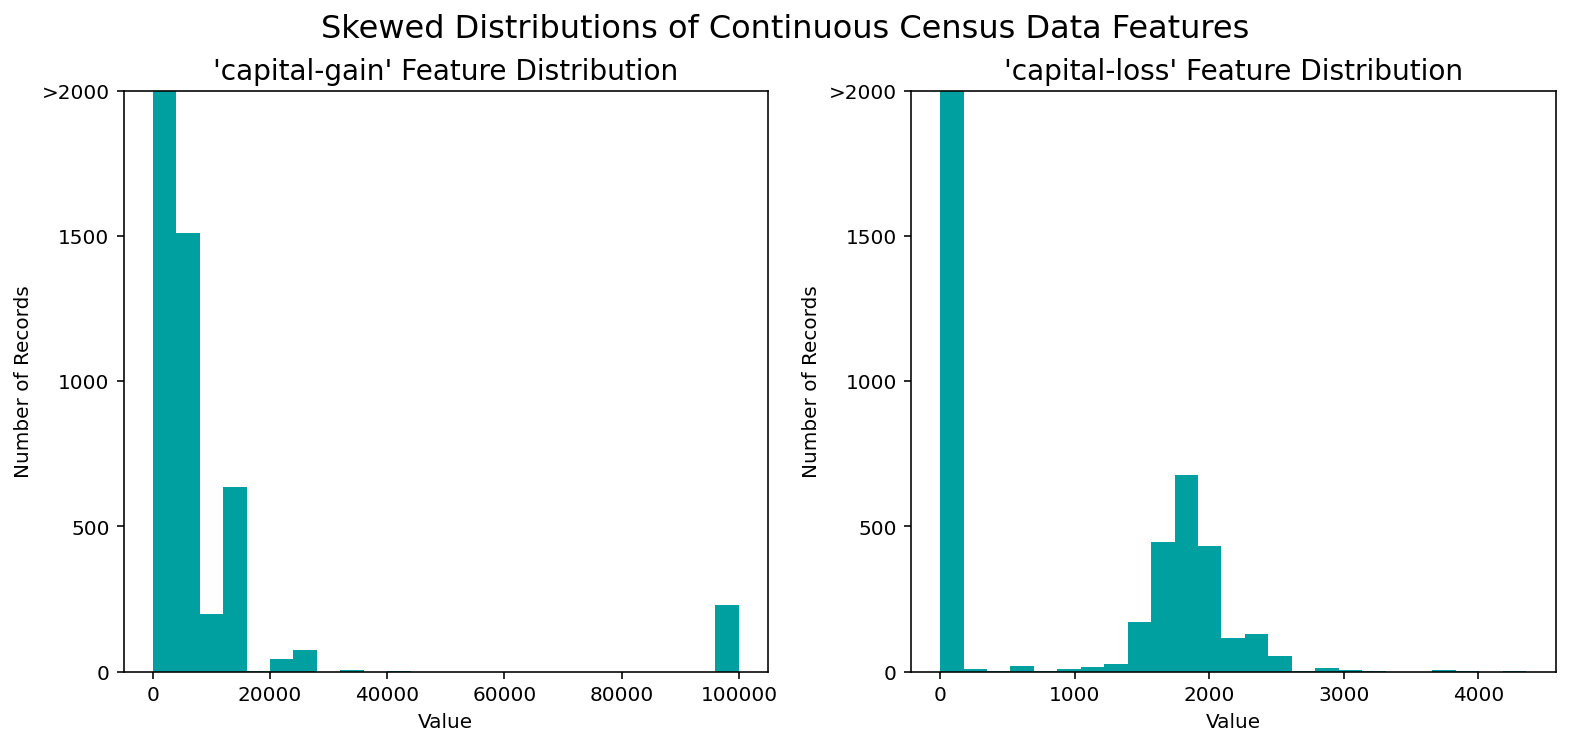

In [24]:
# splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# visualizing skewed continuous features of original data
vs.distribution(data)

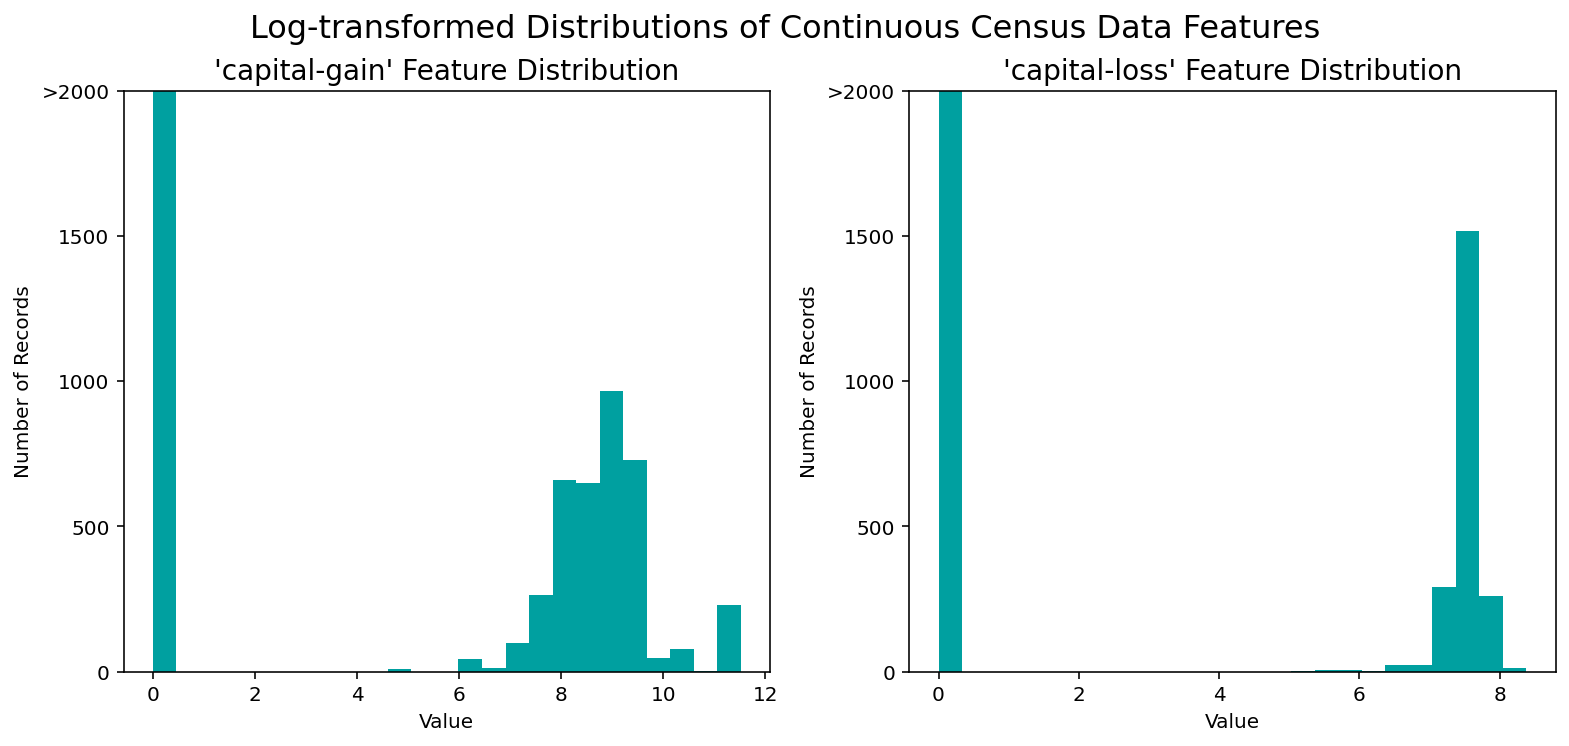

In [25]:
# log-transforming the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [27]:
# initializing a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# displayinfg an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a3d8e6c88>,
      dtype=object)

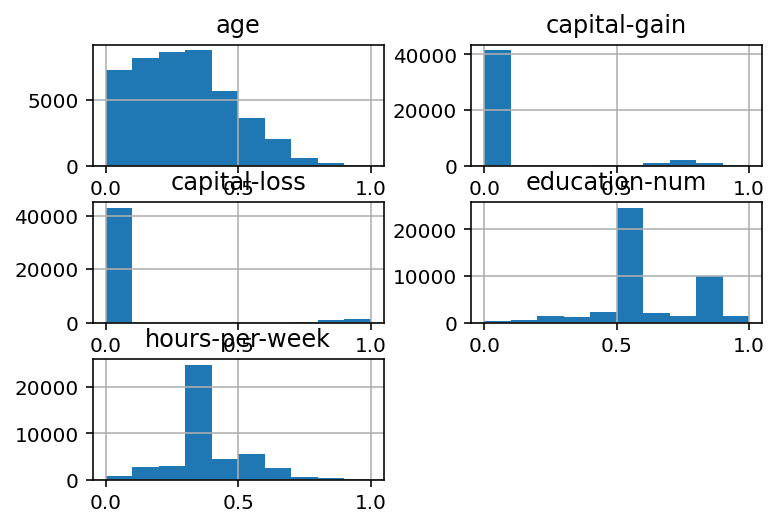

In [43]:
features_log_minmax_transform.hist()

### Implementating Data Preprocessing

In [46]:
features_final = pd.get_dummies(features_log_minmax_transform)
income = data['income'].map({'>50K' : 1, '<=50K' : 0})

encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2,random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


## Evaluating Model Performance

### Metrics and the Naive Predictor

In [50]:
TP = np.sum(income)
FP = income.count() - TP
FN = 0

accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
beta = .5
fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Creating a Training and Predicting Pipeline

In [52]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # getting start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # getting end time
    
    results['train_time'] = end - start
        
    start = time() # getting start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # getting end time
    
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average='macro', beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, average='macro', beta=0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Initial Model Evaluation

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


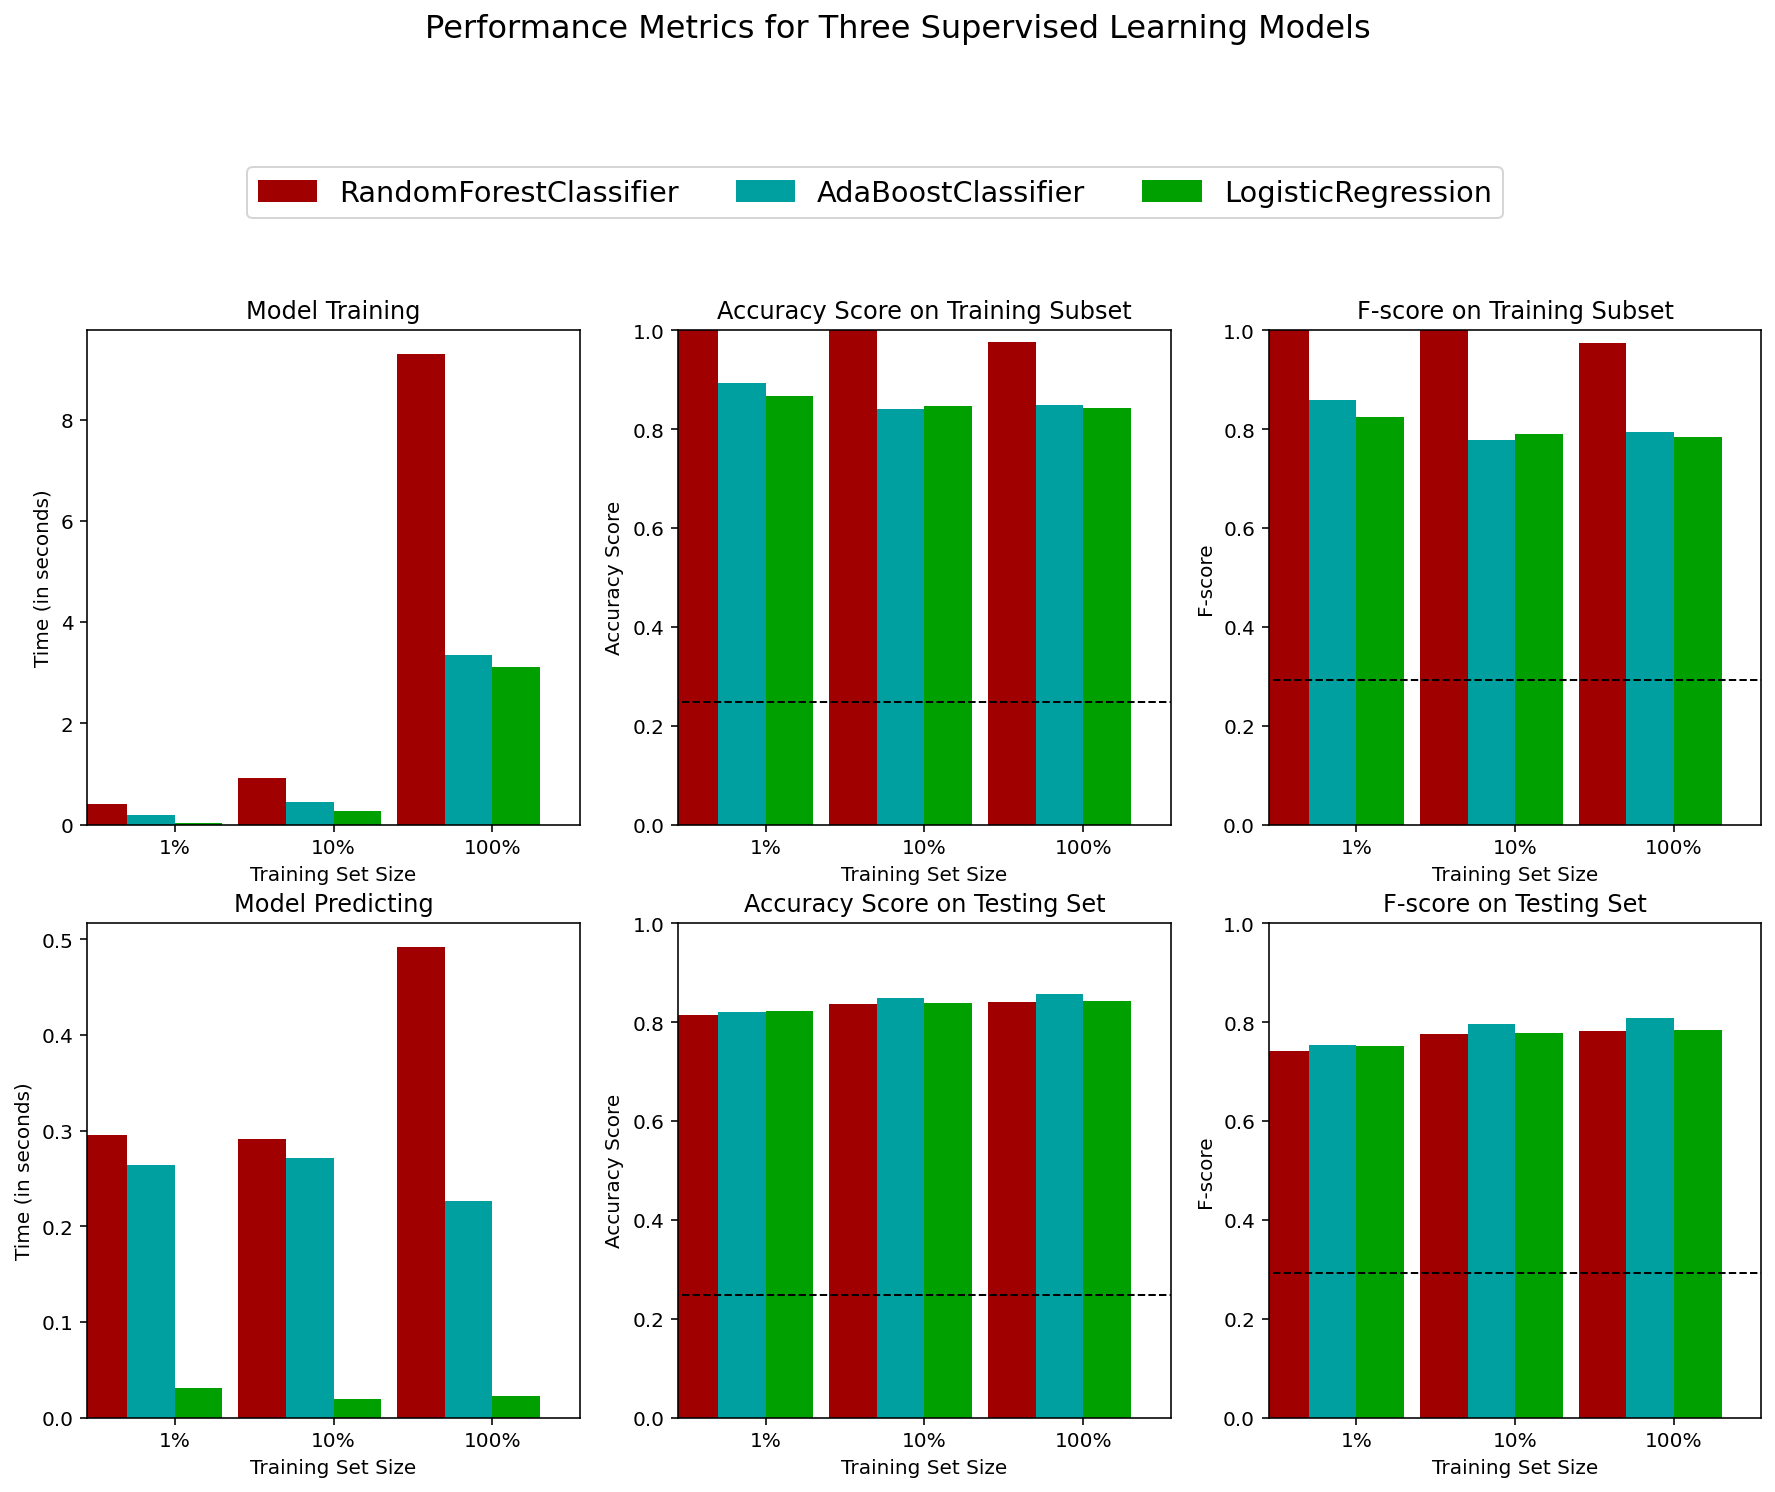

In [55]:
clf_A = RandomForestClassifier(random_state=0)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = LogisticRegression(random_state=0)

samples_100 = len(y_train)
samples_10 = int(samples_100 * .10)
samples_1 = int(samples_100 * .01)

# getting results for all models
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# visualizing evaluation metrics for all models
vs.evaluate(results, accuracy, fscore)

In [56]:
results

{'RandomForestClassifier': {0: {'train_time': 0.4140763282775879,
   'pred_time': 0.2954702377319336,
   'acc_train': 1.0,
   'acc_test': 0.8148148148148148,
   'f_train': 1.0,
   'f_test': 0.7415187374722767},
  1: {'train_time': 0.9221367835998535,
   'pred_time': 0.29140400886535645,
   'acc_train': 1.0,
   'acc_test': 0.8362631288004422,
   'f_train': 1.0,
   'f_test': 0.7755958403981245},
  2: {'train_time': 9.29735255241394,
   'pred_time': 0.4920003414154053,
   'acc_train': 0.9766666666666667,
   'acc_test': 0.8404643449419569,
   'f_train': 0.9745182555780934,
   'f_test': 0.7823597810822691}},
 'AdaBoostClassifier': {0: {'train_time': 0.18268084526062012,
   'pred_time': 0.26396632194519043,
   'acc_train': 0.8933333333333333,
   'acc_test': 0.8206744057490326,
   'f_train': 0.8593952343952345,
   'f_test': 0.7541927412281495},
  1: {'train_time': 0.44558000564575195,
   'pred_time': 0.27111220359802246,
   'acc_train': 0.84,
   'acc_test': 0.849861802100608,
   'f_train': 0.

## Improving Results

Based on the evaluation graphs above, We can see that the AdaBoost model would be the most appropriate for the task of identifying individuals that make more than 50K. We can see that while Random Forests excelled in the training set by a larger margin, it's lead dwindled when used on the test set. This is really important because we want to make sure our model isn't memorizing the training or test data. 

While AdaBoost had the longest **training and testing time to predict** of the other three models, it's test graphs indicate that the **f-score and accuracy score** remained consistent and ended up performing slightly better than the other two on the testing.

Because not all the features we have access to are continuous in nature, and there are no clear primary important features, AdaBoost is great as an ensemble multiple learner model in which multiple not as great models can work together with each of their own learnings to predict with great accuracy. 

### What makes AdaBoost special?

Before we can understand our AdaBoost classifier and how it works, we first have to understand what decision trees are, the default base algorithm used in the AdaBoost classifier. 

Decision Trees are a supervised learning method that builds models in the form of a tree structure. Let’s build a simple example together. 

Let’s say you work at a best buy and you were trying to figure out whether or not a particular customer that comes into your store would buy a computer. Based on your years of experience as a best buy manager, you’d have some data available you could use in aiding your decision making skills. You might first start off with narrowing down a customers age.

Take a look at the below tree graph as you follow along. 

Your previous sales record indicates that it’s likely that someone between the age of 18-35 is going to buy a computer. That was easy - one branch completed with an answer! But what if the customer is less than 18? Your previous data indicates that a customer under 18 is less likely to buy a computer, but if they happen to be a student, the chances are much higher. Great! You’ve completed another branch of the tree. Finally, what if the customer is over 35? Yikes, you might have to check their credit score first. You find out from your previous sales records that if they had a credit score of good or great and are over 35, they’re more likely to walk away with a computer than if they’re credit score is poor. We’ve completed the decision tree and are now left with several branches that lead to a computer sale and a few that lead to no sale!

Now this could come in handy next time you’re deciding whether or not to continue pitching a computer to a new customer! (Granted this fictional scenario is unlikely to happen in a real business setting as age and credit score information will most likely not be provided at the time of purchase!)

![decision-tree](seconddecisiontree.jpg "Title")


Now that we have a basic intuition for decision trees, we can start talking about what a weak learner is and how and why it is used in the AdaBoost classifier and other boosting algorithms.

A weak learner is a learner (algorithm) that is consistently at least more accurate than guessing. Ironically enough, being “weak” isn’t necessarily a prerequisite but we denote them as such because our aim will be to combine them together to create an even stronger learner with their combined decision making powers united. It’s important to note a decision tree is a great weak learner because it is non linear, which makes it very adaptable, it’s fast, and it works better than guessing without any fuss over hyper-parameters (another word for algorithm options). 

Let’s imagine you were trying to build a computer that could categorize hundreds of photos of dog breeds into their unique breed groups. A great week learner, like an unoptimized decision tree, may be especially good at classifying golden retrievers, but fails to see the difference between shepherds and poodles. 

This is where ‘boosting’ comes in boosting algorithms. 

Boosting algorithms work by solving parts of the problem at a time, letting one weak learner at a time give it their best shot. After each weak learner gives it their best shot, they increase the weights of the misclassified items, essentially making it so that the next learner can pay more attention to what it got wrong (sometimes at the expense of getting the previous items wrong).

After everyone has given it their best shot at solving the problem, the AdaBoost algorithm looks to see how confident each learner is for a particular prediction. Let’s say “Is that a golden retriever in this image?” Based on the confidence level for this particular classification question, the AdaBoost algorithm will use all of the learners cumulative decision making power to make the final decision where the learners with the highest confidence have more ‘say’ than learners with lower confidence in their predictions. So your algorithm can answer with confidence, “Is that a golden retriever?”, “Why yes, (based on my learning from the 100 decision trees with each of their confidence levels of their predictions at play) I am 85% sure!”.

In summary, AdaBoost (a boosting algorithm with a decision tree base by default) is great for our current census problem because our feature set has unique features (age, years in schooling etc) in which one independent feature doesn’t immediately stand out as a single identifier of someone who makes more than 50K a year. Having a model that can utilize many differnet classifiers to iteravely improve prediction power of the strong learner is a sure-fire way to a strong model. 

The question we should ask is less “why use a boosting algorithm?” and more like “why shouldn’t we use a boosting algorithm?”. Boosting models are great models to have in your toolkit however they do focus on decreasing bias rather than handling high variance (where there is a lot of noise in your data). You do however have power over the depth of the decision tree used in your model, so lower variance is just a parameter adjustment away!

References:

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- https://medium.com/machine-learning-101/https-medium-com-savanpatel-chapter-6-adaboost-classifier-b945f330af06
- https://educationalresearchtechniques.com/2019/01/07/adaboost-regression-with-python/
https://chrisalbon.com/machine_learning/trees_and_forests/adaboost_classifier/
- https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725
- https://chrisalbon.com/machine_learning/trees_and_forests/adaboost_classifier/
- https://towardsdatascience.com/boosting-the-accuracy-of-your-machine-learning-models-f878d6a2d185

### Model Tuning

In [59]:
clf = AdaBoostClassifier(random_state=0)

parameters = {'n_estimators':[1,10,25,50,100],'learning_rate':[.1,.5,1,2,4]}

# making a fbeta_score scoring object 
scorer = make_scorer(fbeta_score, beta=.5)

# creating gird search object
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

# getting the model estimator
best_clf = grid_fit.best_estimator_
print(best_clf)

# predicting using the un-optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# printing before and after optimization scores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=0)
Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8606
Final F-score on the testing data: 0.7316


### Final Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.8576        |   0.8606        |
| F-score        |     0.7246        |   0.7316        |


While I would aim for a slightly larger sucess margin between the unoptimized and optimized's performance, the optimized model's F-score and accracy score are infact slightly higher than the unoptimized model. This can be explained by our use of GridsearchCV to calculate the best params based on the options that I provided compared to our use of default params in the unoptimized model. 

The optimized model performed wildly better than the naive predictor benchmark (Naive Predictor: Accuracy score: 0.2478, F-score: 0.2917) as expected. 

## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

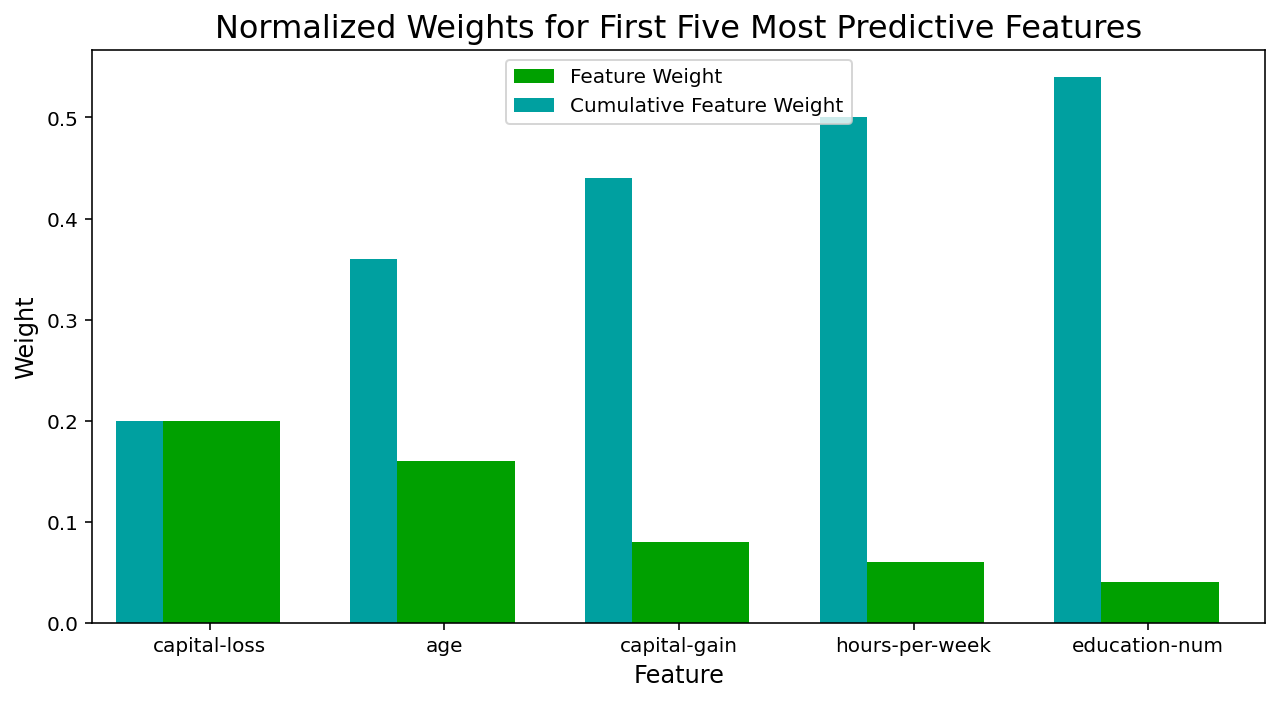

In [60]:
model = AdaBoostClassifier(random_state=0).fit(X_train,y_train)
# grabbing the feature importances from our adaboost classifier
importances = model.feature_importances_

# using our handy visiualization script to plot each feature and it's weight. 
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
Let's try and see how our model does when we reduce the featurespace to only the features that appear important

In [62]:
# dropping less relevant features
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# training on the best model from earlier (when we did a grid search)
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

reduced_predictions = clf.predict(X_test_reduced)

print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8606
F-score on testing data: 0.7316

Final Model trained on reduced data
------
Accuracy on testing data: 0.8325
F-score on testing data: 0.6752


### Overall thoughts on model performance after reducing features

1. The models F-score and accuracy score dropped. This is a little surprising.
2. The reduced data does reduce the training time, but with a larger comprimise in f-score. Depending on which metrics were valuable when evaluating a given model, I would consider, but because f-score and accuracy are are widely used important metrics, I'd most likely shy away using them in this particular situation/prediction task.